# Toxic Comments NLP By Transformer

## build transformer from scratch according to Attention is all we Need paper using pytorch


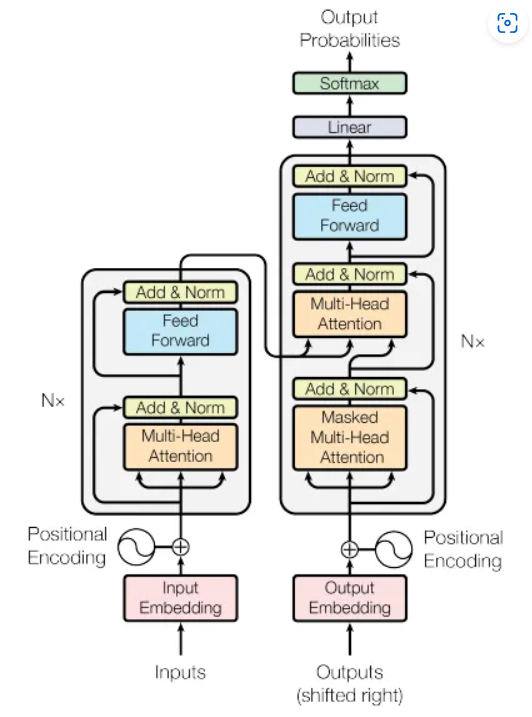

import libraries

In [1]:
import torch
import torch.nn as nn#provides various classes and functions for defining and training neural network models.
import math#provides mathematical functions and constants.

 input embeddings play a crucial role in many NLP and machine learning applications by providing a way to represent and process textual or sequential data in a format that neural networks can effectively learn from. They capture the semantic relationships between tokens and enable models to understand and generate natural language text.

In [2]:
class InputEmbedding(nn.Module):
    def __init__(self, input_vocab_size, d_model):
        super(InputEmbedding, self).__init__()
        
        self.embedding = nn.Embedding(input_vocab_size, d_model)

    def forward(self, x):
        # x is a tensor of shape (batch_size, seq_length)
        # Apply the embedding layer
        embedded_x = self.embedding(x)
        return embedded_x

This InputEmbedding class is typically used as a component within a larger neural network, especially in natural language processing tasks. It's responsible for the initial transformation of input tokens into continuous vector representations, making them suitable for further processing by other layers of the neural network

## Build positional Encoding

it imparts information about word positions, enabling the model to understand and leverage the sequential nature of text data. This is especially important for tasks where word order plays a significant role in determining the meaning or sentiment of a sentence.

In [3]:
class PositionalEncoding(nn.Module):#nn.Module, indicating that it's a PyTorch neural network module.
    def __init__(self, d_model, max_seq_length):#d_model,It determines the size of the positional encodings.
        #max_seq_length:which is the maximum number of tokens in your input sequence.
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)
#This sets up a dropout layer with a dropout probability of 10% (0.1). Dropout is a regularization technique used to prevent overfitting in neural networks.        
        pe = torch.zeros(max_seq_length, d_model)#- This creates a tensor pe filled with zeros. Its shape is (max_seq_length, d_model).
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
#This generates a tensor position containing a sequence of numbers from 0 to max_seq_length - 1        
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#This calculates the values of a term used in the positional encoding formula.    
        pe[:, 0::2] = torch.sin(position * div_term)
# This computes the sine component of the positional encoding and assigns it to every second column of the pe tensor.    
        pe[:, 1::2] = torch.cos(position * div_term)
#This computes the cosine component of the positional encoding and assigns it to the remaining columns of the pe tensor.    
        pe = pe.unsqueeze(0).transpose(0, 1)
#This reshapes the pe tensor to have a shape of (max_seq_length, 1, d_model) and then transposes it to have a final shape of (1, max_seq_length, d_model)    
        self.register_buffer('pe', pe)
#buffer:This is necessary because the positional encoding doesn't contain any learnable parameters but should be included in the model's state.
    def forward(self, x):
# It takes an input tensor x.        
        x = x + self.pe[:x.size(0), :]
#This line adds the positional encoding tensor self.pe to the input tensor x. The [:x.size(0), :]    
        return self.dropout(x)# the output tensor x is passed through the dropout layer

this code defines a PyTorch module for positional encoding, which is essential for transformer-based models to incorporate information about the positions of words in the input sequence. It calculates positional embeddings based on a mathematical formula involving sine and cosine functions.

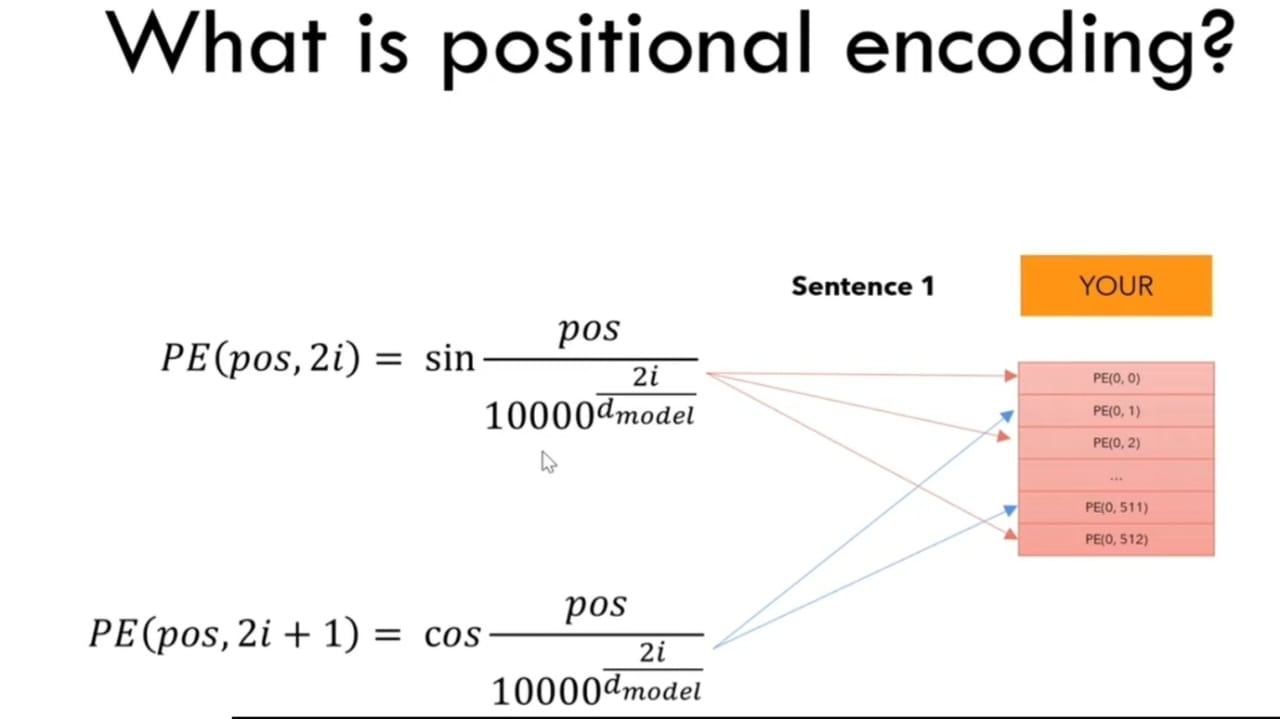

## build Multi head Attention 

multi-Head Attention in text classification allows the model to capture context and relationships between words in the input text, making it highly effective for understanding and classifying text data, even when dealing with long sequences and complex dependencies between words.

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):#num_heads: This is the number of attention heads.
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
#This assertion checks that d_model is divisible by num_heads to ensure that the dimensions align correctly for the multi-head attention mechanism.        
        self.num_heads = num_heads
        self.d_head = d_model // num_heads
# This calculates the dimension of each head by dividing d_model by num_heads.
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
#These lines define linear transformation layers using nn.Linear. 
#These layers are used to project the input queries, keys, and values into the multi-head attention space.
    def split_heads(self, x):
        batch_size, seq_len, d_model = x.size()
        x = x.view(batch_size, seq_len, self.num_heads, self.d_head)
        return x.permute(0, 2, 1, 3)  # Reshape for multi-head attention
#This method is used to split the input tensor x into multiple heads.
#It reshapes the input tensor to have shape (batch_size, seq_len, num_heads, d_head).
    def forward(self, query, key, value, mask=None):
        Q = self.split_heads(self.W_q(query))
        K = self.split_heads(self.W_k(key))
        V = self.split_heads(self.W_v(value))
#These lines project the query, key, and value tensors into the multi-head attention space by applying the linear transformation layers and then splitting them into multiple heads.
        scores = torch.matmul(Q, K.permute(0, 1, 3, 2)) / (self.d_head**0.5)
#This calculates the attention scores using matrix multiplication between the query and key tensors
        if mask is not None:
            scores += mask.unsqueeze(1)
#if a mask is provided, it is added to the attention scores to apply masking.
        attention_weights = torch.nn.functional.softmax(scores, dim=-1)
# This computes the softmax function along the last dimension of the attention scores to obtain attention weights.    
        weighted_sum = torch.matmul(attention_weights, V)
#This computes the weighted sum of the values according to the attention weights.    
        concat_heads = weighted_sum.permute(0, 2, 1, 3).contiguous().view(query.size(0), -1, self.num_heads * self.d_head)
#reshapes and concatenates the output from multiple heads.
        output = self.W_o(concat_heads)
        return output
#the concatenated result is projected back into the original space using the linear transformation layer W_o    

this code defines a Multi-Head Attention module, which is a fundamental component of transformer-based models. It takes input queries, keys, and values, calculates attention scores, applies attention masking if necessary, computes attention weights, and produces the final output by concatenating and projecting the results from multiple attention heads.






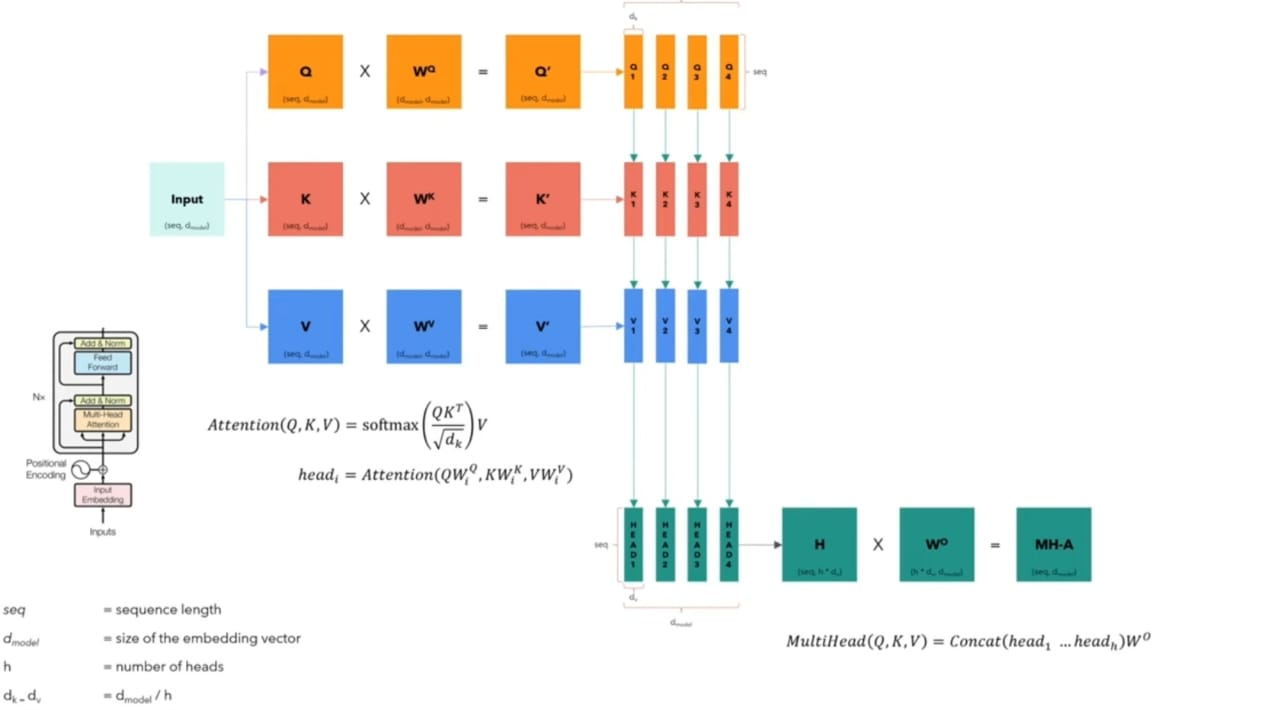

# Build Position wise FeedForward

This PFF layer can be used in a text classification model as part of the encoder block, following the Multi-Head Attention layer. It allows the model to capture complex patterns and relationships in the data before making classification predictions.

In [5]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
#d_ff: This parameter represents the dimensionality of the intermediate layer in the feedforward neural network.
#This layer is responsible for introducing non-linearity to the model through the subsequent ReLU activation.
        self.relu = nn.ReLU()
#This line defines the rectified linear unit (ReLU) activation function,which introduces non-linearity by applying the element-wise ReLU function to its input.    
        self.linear2 = nn.Linear(d_ff, d_model)
#This line defines the second linear layer in the feedforward network.
    def forward(self, x):
        return self.linear2(self.relu(self.linear1(x)))
#  In the forward pass, the input tensor x is first passed through the first linear layer (self.linear1). 
# Then, the ReLU activation function is applied (self.relu).
# Finally, the result is passed through the second linear layer (self.linear2). The output of the second linear layer is the final output of the feedforward network.    
    
    

PositionwiseFeedForward module is responsible for transforming the input tensor at each position in the sequence through a feedforward neural network. This transformation allows the model to capture complex relationships and patterns in the data

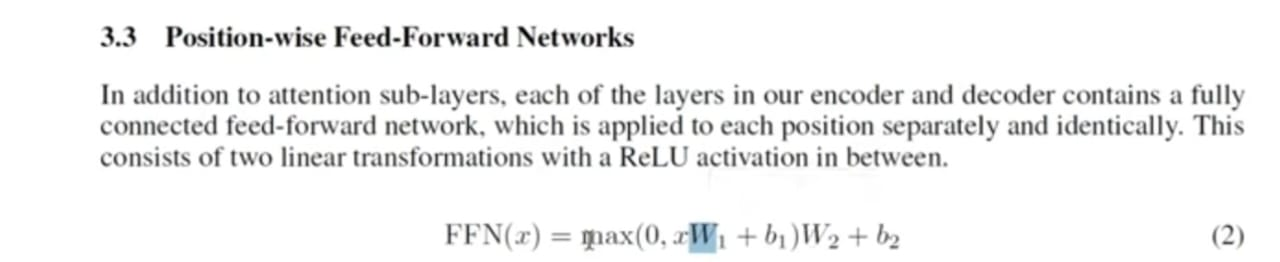

## Build layer normalization

The key idea is to incorporate LayerNorm within the model architecture to improve training stability and classification performance.

In [6]:
class LayerNorm(nn.Module):
    def __init__(self, features, epsilon=1e-6):
#features: This parameter specifies the number of features (dimensions) that will be normalized independently. 
#In other words, it defines the size of the last dimension of the input tensor. 
#epsilon:improve numerical stability during normalization. 
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
#This line defines a learnable parameter gamma (scaling factor) as a PyTorch parameter tensor.
#It's initialized with ones and has the same shape as the specified number of features.        
        self.beta = nn.Parameter(torch.zeros(features))
# This line defines another learnable parameter beta (bias) as a PyTorch parameter tensor.
#It's initialized with zeros and has the same shape as the specified number of features.    
        self.epsilon = epsilon

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)#This computes the mean independently for each feature.
        std = x.std(dim=-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.epsilon) + self.beta
#The normalization is done by subtracting the mean and dividing by the standard deviation (plus epsilon for stability).    

the LayerNorm module is a normalization technique applied to neural network activations. It scales and shifts the activations to make them have a mean of zero and a standard deviation of one, independently for each feature. This helps improve the training and generalization of neural networks by reducing the impact of feature scale variations.

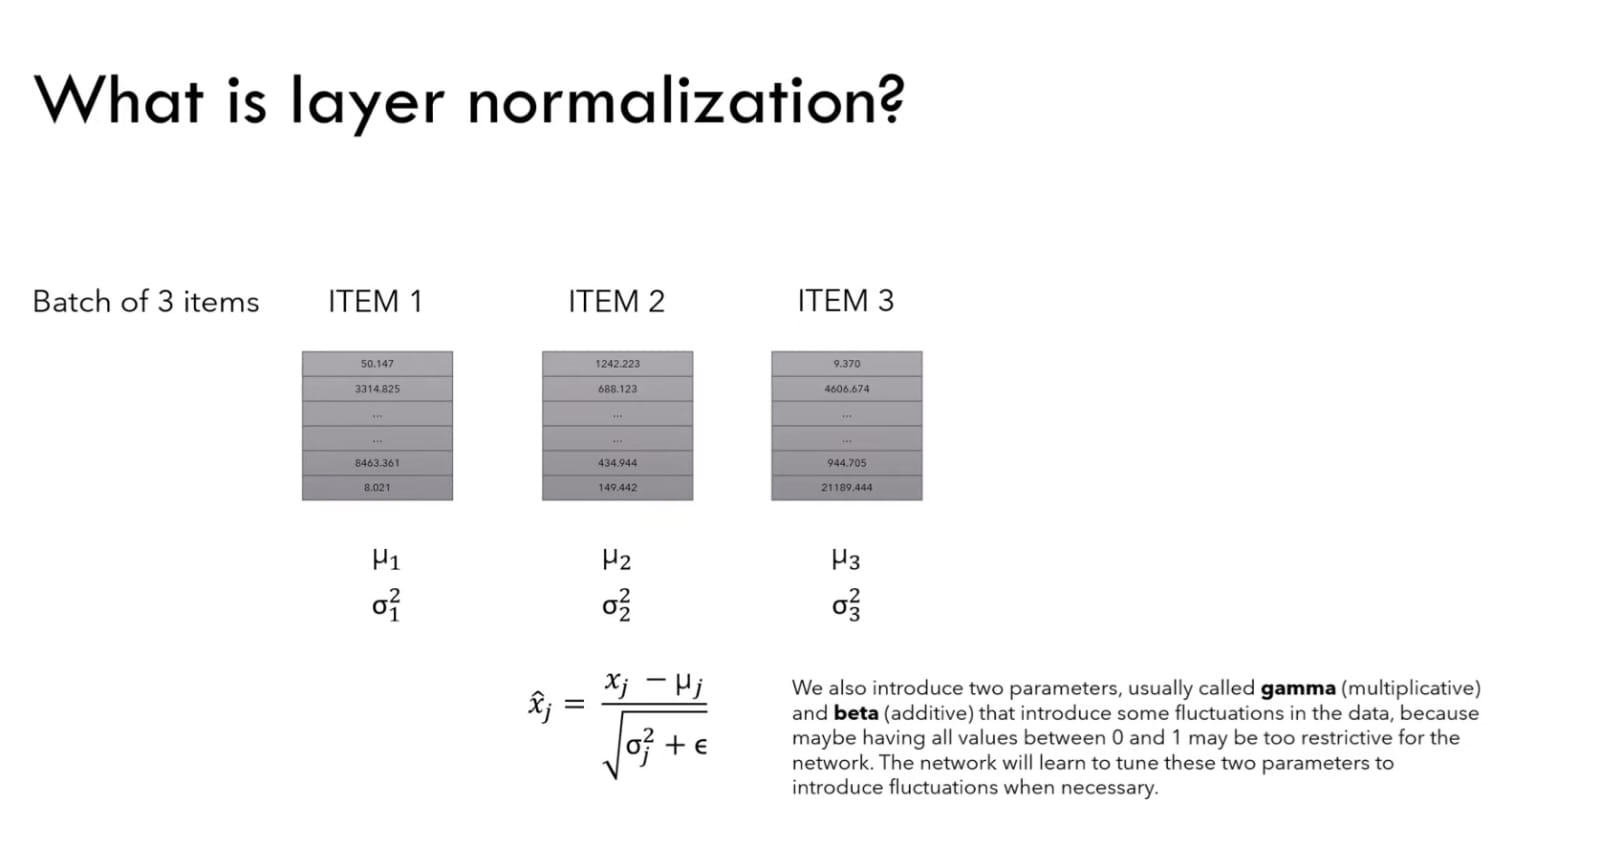

### I apply residual connections in encoder and decoder layer class

residual connections are a fundamental architectural innovation that has had a significant impact on the training of deep neural networks. They address issues related to gradient flow, optimization, and the ability to learn complex mappings, making it possible to train deeper and more powerful models

## Build Encoder

 The key idea is to use a transformer-based encoder to capture contextual information and patterns in the text data, which can then be used for accurate classification.

In [7]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        
        # Multi-Head Self-Attention
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=dropout)
        
        # Position-wise Feed-Forward Network
        self.feed_forward = PositionwiseFeedForward(d_model, d_ff)
        self.norm2 = LayerNorm(d_model)#This initializes a Layer Normalization layer for the output of the Position-wise Feed-Forward Network.
        self.dropout2 = nn.Dropout(p=dropout)#his initializes a dropout layer to be applied after the Position-wise Feed-Forward Network.
    
    def forward(self, x, mask=None):
        # Multi-Head Self-Attention
        attention_output = self.self_attention(x, x, x, mask)
# This line applies the Multi-Head Attention mechanism to the input tensor x.
#It computes attention scores using x as both the query, key, and value.        
        x = x + self.dropout1(attention_output)
#This adds the result of attention to the original input x after applying dropout.    
        x = self.norm1(x)
#Layer normalization is applied to the output of the attention mechanism.        
        # Position-wise Feed-Forward Network
        ffn_output = self.feed_forward(x)# This line applies the Position-wise Feed-Forward Network to the output of the attention layer.
        x = x + self.dropout2(ffn_output)
#This adds the result of the feed-forward network to the previous output x after applying dropout        
        x = self.norm2(x)
#: Layer normalization is applied to the output of the feed-forward network.        
        return x

he TransformerEncoderLayer represents a single layer in the transformer encoder. It consists of Multi-Head Self-Attention and a Position-wise Feed-Forward Network, both of which contribute to capturing contextual information and patterns in the data. Layer normalization and dropout are applied to stabilize and regularize the output of these components, respectively. 

## build Decoder

In [8]:
import torch.nn.functional as F

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        
        # Multi-Head Self-Attention Layer
        self.self_attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
#This layer allows the model to attend to different parts of the input sequence simultaneously.        
        
        # Layer Normalization
        self.norm1 = nn.LayerNorm(d_model)
# It performs layer normalization on the output of the self-attention layer.        
        # Position-wise Feed-Forward Layer
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
# #which is applied to the output of the layer normalization.
# It consists of two linear transformations with a ReLU activation in between. 
# The first linear layer reduces the dimensionality of the input,
# and the second linear layer brings it back to the original dimension.        
        # Layer Normalization
        self.norm2 = nn.LayerNorm(d_model)
#is another layer normalization applied after the position-wise feed-forward network.        
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, self_mask=None, enc_mask=None):
        # Multi-Head Self-Attention
        attention_output, _ = self.self_attention(x, x, x, attn_mask=self_mask)
        
        # Residual Connection and Layer Normalization
        x = self.norm1(x + self.dropout(attention_output))
        
        # Position-wise Feed-Forward Network
        ff_output = self.feed_forward(x)
        
        # Residual Connection and Layer Normalization
        x = self.norm2(x + self.dropout(ff_output))
        
        return x

# In the forward method, the input x undergoes multi-head self-attention. The resulting attention_output is added to the original x,
# creating a residual connection. Layer normalization is then applied to the sum.
    
    
    

he output of the layer normalization is passed through the position-wise feed-forward network. Again, a residual connection is established by adding the original x to the output of the feed-forward network. Layer normalization is applied again.

The final output is returned, which represents the processed input after going through the multi-head self-attention, feed-forward network, and residual connections.

## combine between decoder and encoder layers

In [9]:
class Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, d_model, num_heads, d_ff, input_vocab_size, output_vocab_size, max_seq_length, dropout=0.1):
        super(Transformer, self).__init__()

        # Input Embeddings
        self.embedding = nn.Embedding(input_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Transformer Encoder
        encoder_layers = []
        for _ in range(num_encoder_layers):
            encoder_layer = TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            encoder_layers.append(encoder_layer)
        self.encoder = nn.Sequential(*encoder_layers)
 #This line creates a sequential module (self.encoder) that consists of the encoder layers stored in encoder_layers. 
#The sequential module applies each encoder layer in sequence during the forward pass.       
        
        decoder_layers = []
        for _ in range(num_decoder_layers):
            decoder_layer = TransformerDecoderLayer(d_model, num_heads, d_ff, dropout)
            decoder_layers.append(decoder_layer)
        self.decoder = nn.Sequential(*decoder_layers)

        self.output_layer = nn.Linear(d_model, output_vocab_size)

    def forward(self, source, target, source_mask=None, target_mask=None):
# This line defines the forward method for the Transformer model,
#which specifies how input data is processed during the forward pass.

# source: Input sequence (source) tensor.

# target: Target sequence tensor (only used in sequence-to-sequence tasks).

# source_mask=None: Mask for source sequence.

# target_mask=None: Mask for target sequence.        
        
        
        
        # Input Embeddings
        source = self.embedding(source)
        source = self.positional_encoding(source)

        # Transformer Encoder
        encoder_output = self.encoder(source, source_mask)

        if target is not None:
            target = self.embedding(target)
            target = self.positional_encoding(target)
            decoder_output = self.decoder(target, target_mask)
        else:
            decoder_output = None

        if decoder_output is not None:
            output = self.output_layer(decoder_output)
        else:
            output = None

        return output


The forward method proceeds to process the input sequences through the model, which includes input embeddings, encoder layers, and the output layer.

## build text classification class to build the model and use it in train ,test,validation 

In [10]:
class TransformerTextClassifier(nn.Module):
    def __init__(self, num_encoder_layers, d_model, num_heads, d_ff, input_vocab_size, num_classes, max_seq_length, dropout=0.1):
        super(TransformerTextClassifier, self).__init__()
# num_encoder_layers: The number of Transformer encoder layers in the model.
# d_model: The dimensionality of the model's embeddings and hidden states.
# num_heads: The number of attention heads in the multi-head self-attention mechanism.
# d_ff: The size of the feedforward neural network within each encoder layer.
# input_vocab_size: The size of the input vocabulary (number of unique tokens).
# num_classes: The number of classes in the classification task.
# max_seq_length: The maximum sequence length for input sequences.
# dropout: A dropout rate applied throughout the model (default is 0.1).

        # Input Embeddings
        self.embedding = nn.Embedding(input_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        # Stack of Transformer Encoder Layers
        encoder_layers = [] #A stack of Transformer encoder layers is created and stored in self.encoder
        for _ in range(num_encoder_layers):
            encoder_layer = TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            encoder_layers.append(encoder_layer)
        self.encoder = nn.Sequential(*encoder_layers)

        # Classification Head
        self.classification_head = nn.Sequential(
            nn.Linear(d_model, 256),  # Example hidden layer size, adjust as needed
#A linear layer (nn.Linear) that reduces the dimensionality of the transformer output to 256 (we can adjust this as needed).            
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(256, num_classes)  # Output layer with num_classes for classification #Another linear layer that produces the final classification scores with num_classes output units.
        )

    def forward(self, x):
        # Input Embeddings
        x = self.embedding(x)
        x = self.positional_encoding(x)

        # Transformer Encoder
        x = self.encoder(x)

        # Classification Head
        class_scores = self.classification_head(x[:, 0, :])  # Assuming you want to classify the whole sequence
#The classification head operates on the output of the transformer, specifically on the hidden representation of the [CLS] token (the first token) by selecting x[:, 0, :].
        return class_scores
#The output of the classification head is a tensor of shape [batch_size, num_classes], containing the predicted class scores for each input sequence in the batch.

The forward method proceeds to process the input sequence through the model, which includes input embeddings, multiple Transformer encoder layers, and the classification head. 

 It's designed for text classification, where you provide a sequence of tokens as input and get class scores as output, making it suitable for tasks like sentiment analysis, document classification, or any other text classification problem

## Read the data

In [11]:
import pandas as pd # for read files

firstly ,we will read the file

In [12]:
df=pd.read_csv("C:/Users/CLARA/Downloads/Attachment (4)/train.csv")

we read the file and store it in df

In [13]:
df.shape
#to know the shape of data(rows/columns)

(159571, 8)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


there isn't null values.comment_text,id is string but the the rest of data is  integer

we will show first 10 rows to know about the data

In [15]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [16]:
df.loc[3,'comment_text']

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

we see that we should clean the text data to begin the text preprocessing

## Clean the  text data

In [17]:
!pip install contractions

Defaulting to user installation because normal site-packages is not writeable


In [18]:
import string #to use it in removing punctuation
import re #The re module stands for "regular expressions," and it provides powerful tools for working with patterns and manipulating strings.
#With the re module, we can perform various text operations, such as searching for patterns
import contractions
#This'contractions' library helps in expanding contractions in text, for example, converting "I'm" to "I am" or "you'll" to "you will." 
#so when we remove punctuation donot affect the word so we should make it before removing Punctuation

i will define function replace_not to use it in function clean(can\not-->can not)

In [19]:
def replace_not(text):
    # Define a regular expression pattern to match "\not" with any number of backslashes
    pattern = r'\\*not'
    
    # Use re.sub() to replace the pattern with a space followed by "not"
    transformed_text = re.sub(pattern, ' not', text)
    
    return transformed_text

In [20]:
def clean(text):
    # Convert text to lowercase
    ans = text.lower()
    
    # Expand contractions in text
    ans = contractions.fix(ans)
    ans=replace_not(ans)
    
    # Remove repeating punctuation
    ans = re.sub(r'(!|.)\1+', '', ans)
    
    PUNCT_TO_REMOVE = string.punctuation
    
    # Remove punctuation
    ans = ans.translate(str.maketrans('','', PUNCT_TO_REMOVE))
    
    #replace middle dot
    ans= ans.replace("·", "")
    
    # Remove digits
    ans = ''.join([i for i in ans if not i.isdigit()])
    
    # Remove extra whitespace
    ans = " ".join(ans.split())
    
    # Define a regular expression pattern for emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    # Remove emojis and symbols like ✆
    ans = emoji_pattern.sub(r'', ans)
    return ans         
        

In [21]:
df['comment_text'] = df['comment_text'].apply(clean)

as we clean the  text data column(comment_text)

In [22]:
df.loc[3,'comment_text']

'more i can not make any real suestions on improvement i wondered if the section statistics should be later on or a subsection of types of aidentsi think the references may nd tidying so that they are a in the exact same format ie date format etc i can do that later on if noone else does first if you have any preferences for formaing style on references or want to do it yourself please let me know there aears to be a backlog on articles for review so i gue there may be a delay until a reviewer turns up it is listed in the relevant form eg wikipediagdarticlenominationstransport'

we will know if balanced or not

In [23]:
cols=['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
df['Toxic']=df[cols].max(axis=1).apply(lambda x: "Toxic" if x ==1 else "Non-Toxic")

It uses the .max(axis=1) method to find the maximum value along each row of the specified columns (cols). Since these columns contain binary values (0 or 1), taking the maximum value effectively checks if any of the categories are marked as toxic for a given comment. If at least one category is marked as toxic (i.e., it has a value of 1), the maximum value for that row will be 1.

the "Toxic" column is a binary label that indicates whether a comment is considered toxic or not based on the presence or absence of toxicity indicators in the specified columns. If any of the toxicity columns have a value of 1 for a particular comment, it is labeled as "Toxic"; otherwise, it is labeled as "Non-Toxic."

In [24]:
clean = len(df[df.Toxic=="Non-Toxic"])
toxic = len(df[df.Toxic=="Toxic"])

In [25]:
print("Toxic Comments count:",toxic)
print("toxic percentage %.2f"%(toxic/len(df)*100))

Toxic Comments count: 16225
toxic percentage 10.17


In [26]:
print("Toxic Comments count:",clean)
print("toxic percentage %.2f"%(clean/len(df)*100))

Toxic Comments count: 143346
toxic percentage 89.83


so we can see that data is not highly balanced so we will resovle it using regularization in transformer(dropout)

convert toxic to 1 and non toxic to zaro

In [27]:
df['Toxic']=df['Toxic'].apply(lambda x:1 if x =='Toxic' else 0)

### Apply tokenization

In [28]:
import nltk #for tokenization
# Ensure the 'punkt' resource is downloaded
nltk.download('punkt')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\CLARA\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
# the tokenization function
def token(text):
    text = nltk.word_tokenize(text)
    return text

Tokenize the text data

In [30]:
df['comment_text2'] =df['comment_text'].apply(token)

In [31]:
df.loc[3,'comment_text2']

['more',
 'i',
 'can',
 'not',
 'make',
 'any',
 'real',
 'suestions',
 'on',
 'improvement',
 'i',
 'wondered',
 'if',
 'the',
 'section',
 'statistics',
 'should',
 'be',
 'later',
 'on',
 'or',
 'a',
 'subsection',
 'of',
 'types',
 'of',
 'aidentsi',
 'think',
 'the',
 'references',
 'may',
 'nd',
 'tidying',
 'so',
 'that',
 'they',
 'are',
 'a',
 'in',
 'the',
 'exact',
 'same',
 'format',
 'ie',
 'date',
 'format',
 'etc',
 'i',
 'can',
 'do',
 'that',
 'later',
 'on',
 'if',
 'noone',
 'else',
 'does',
 'first',
 'if',
 'you',
 'have',
 'any',
 'preferences',
 'for',
 'formaing',
 'style',
 'on',
 'references',
 'or',
 'want',
 'to',
 'do',
 'it',
 'yourself',
 'please',
 'let',
 'me',
 'know',
 'there',
 'aears',
 'to',
 'be',
 'a',
 'backlog',
 'on',
 'articles',
 'for',
 'review',
 'so',
 'i',
 'gue',
 'there',
 'may',
 'be',
 'a',
 'delay',
 'until',
 'a',
 'reviewer',
 'turns',
 'up',
 'it',
 'is',
 'listed',
 'in',
 'the',
 'relevant',
 'form',
 'eg',
 'wikipediagdarticle

so we cannot remove stop words as that it  affects the meaning

## Apply stemming

In [32]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer("english")

def stem(text):
    stemmed_tokens = [stemmer.stem(word) for word in text]#to make stemming as to restore rhe words to the origin words
    #it takes every token and restore into origin word
    return stemmed_tokens

Apply stemming on text (tokens) data 

In [33]:
df['comment_text2'] =df['comment_text2'].apply(stem)#transform words into a common form

In [34]:
df.loc[3,'comment_text2']

['more',
 'i',
 'can',
 'not',
 'make',
 'ani',
 'real',
 'suestion',
 'on',
 'improv',
 'i',
 'wonder',
 'if',
 'the',
 'section',
 'statist',
 'should',
 'be',
 'later',
 'on',
 'or',
 'a',
 'subsect',
 'of',
 'type',
 'of',
 'aidentsi',
 'think',
 'the',
 'refer',
 'may',
 'nd',
 'tidi',
 'so',
 'that',
 'they',
 'are',
 'a',
 'in',
 'the',
 'exact',
 'same',
 'format',
 'ie',
 'date',
 'format',
 'etc',
 'i',
 'can',
 'do',
 'that',
 'later',
 'on',
 'if',
 'noon',
 'els',
 'doe',
 'first',
 'if',
 'you',
 'have',
 'ani',
 'prefer',
 'for',
 'forma',
 'style',
 'on',
 'refer',
 'or',
 'want',
 'to',
 'do',
 'it',
 'yourself',
 'pleas',
 'let',
 'me',
 'know',
 'there',
 'aear',
 'to',
 'be',
 'a',
 'backlog',
 'on',
 'articl',
 'for',
 'review',
 'so',
 'i',
 'gue',
 'there',
 'may',
 'be',
 'a',
 'delay',
 'until',
 'a',
 'review',
 'turn',
 'up',
 'it',
 'is',
 'list',
 'in',
 'the',
 'relev',
 'form',
 'eg',
 'wikipediagdarticlenominationstransport']

i will choose 40% as first 63828 rows 

we should know the number of  stemming tokens in 63828 40% before using in transformer as input vocab size 

In [37]:
unique_tokens = set(word for sentence_tokens in df['comment_text2'][:63828] for word in sentence_tokens)
input_vocab_size = len(unique_tokens)

we will know vocab input

In [38]:
input_vocab_size

128728

128728 input voab size

we should know max_length of input to use it in transformer

In [39]:
max_length = 0

# Iterate through tokenized sequences and calculate lengths
for sentence_tokens in df['comment_text2'][:63828]:
    sequence_length = len(sentence_tokens)
    if sequence_length > max_length:
        max_length = sequence_length

print("Maximum sequence length in the column of text:", max_length)

Maximum sequence length in the column of text: 1403


max_length of input 1403

## Apply Bag of words

In [40]:
import numpy as np
from collections import Counter
#The Counter class is a convenient and useful tool for counting the occurrences of elements in a collection

Function about bag of words

In [41]:
def bagOfWords(text):#Python function called bagOfWords(text) that takes a list of words as input and returns a Bag of Words (BoW) vector representing the word frequencies in that list
# Create a vocabulary from all the unique words
    vocab = sorted(set(text))
    bow_vector = np.zeros(len(vocab))# The length of this array is equal to the size of the vocabulary created in the previous step

# Count word occurrences and fill in the BoW vector
    word_counts = Counter(text)
# This line uses the Counter function from Python's collections module to count the occurrences of each word in the input list (text). It creates a dictionary-like object (word_counts) where each word is a key, and its count is the associated value.
    for word, count in word_counts.items():
        word_index = vocab.index(word)#This line finds the index of the current word in the sorted vocabulary (vocab).
        bow_vector[word_index] = count#how many times it appears in the input list
    return bow_vector

Apply bag of words to know the occurrences of each stemming token and store it in new column in df

In [42]:
df['comment_Bag'] =df['comment_text2'].apply(bagOfWords)

In [43]:
df.loc[3,'comment_Bag']

array([5., 1., 1., 2., 1., 1., 1., 3., 2., 1., 1., 2., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 2., 1., 1., 4., 1., 3., 1., 2., 1., 2., 1., 2., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 2., 5., 2., 1., 1., 1., 2., 1., 2.,
       1., 1., 1., 2., 1., 1., 1., 1., 2., 4., 2., 1., 1., 1., 2., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

import libraries to use it 

In [53]:
from sklearn.model_selection import train_test_split # to split the data
from torch.utils.data import Dataset, DataLoader.
#class is another essential component in PyTorch for handling data. 
#It helps in creating iterable data loaders that can be used in training and testing loops

convert every row to tenser to use in transformer

In [54]:
def make_tensor(row):
    return torch.tensor(row, dtype=torch.float32)

convert to tensor and store it in new column in df

In [55]:
df['comment_text3'] = df['comment_Bag'].apply(make_tensor)

In [56]:
X=df['comment_text3'][:63828] #40%
y=df['Toxic'][:63828]#40%
y=torch.tensor(y)#convert target row to tensor

In [57]:
y

tensor([0, 0, 0,  ..., 0, 0, 0])

Split X and y into train and test

In [58]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


### Apply padding on x train tensor 

we should apply padding before use it in data loader before used it in model train

In [59]:
max_length = max(len(tensor) for tensor in X_train)# tow know max length tensor in X_train
X_train_padded = [torch.cat([tensor, torch.zeros(max_length - len(tensor))]) for tensor in X_train]#padding with zeros tensors

X_train_stacked = torch.stack(X_train_padded, dim=0)#This line stacks the tensors in the list X_train_padded along dimension 0. 
X_train_stacked=X_train_stacked.long()#convert it to long
X_train_stacked

tensor([[5, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [3, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [60]:
batch_size = 32# Adjust as needed
train_dataset = list(zip(X_train_stacked, y_train))#combine between Xtrain,ytrain
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)#make dataloader for train dataset
#The DataLoader class is another essential component in PyTorch for handling data.
#It helps in creating iterable data loaders that can be used in training
# Now, train_loader contains both X_train and y_train in batches for training.
train_loader

In [62]:
# Define hyperparameters
num_encoder_layers = 6
d_model = 512
num_heads = 8
d_ff = 2048
input_vocab_size = 128728  # Replace with your actual vocabulary size
num_classes = 2  # Number of classes for classification
max_seq_length =1403 # Maximum sequence length in your data
dropout = 0.1

In [63]:
import torch.optim as optim# to use to optimize the model i will use it during training
from torch.nn.utils.rnn import pad_sequence

In [64]:
# Create the Text Classification Transformer model
text_classifier = TransformerTextClassifier(num_encoder_layers, d_model, num_heads, d_ff, input_vocab_size, num_classes, max_seq_length, dropout)
# make object text_classifier of class TransformerTextClassifier

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(text_classifier.parameters(), lr=0.001)

# Training loop# Training loop
epochs = 1 #This sets the number of training epochs.
for epoch in range(epochs):#This initiates a loop that iterates for the specified number of epochs
    text_classifier.train()
    #This sets the text_classifier model in training mode.
    total_loss = 0.0 #This initializes a variable to keep track of the total loss for the current epoch
    for batch_x, batch_y in train_loader:
#train_loader. In each iteration, batch_x represents a batch of input data, and batch_y represents the corresponding batch of target labels.        
        optimizer.zero_grad()
#It's necessary to reset gradients at the beginning of each batch before computing gradients during backpropagation    
        outputs = text_classifier(batch_x)#The model should output class scores for each input sample.
        loss = criterion(outputs, batch_y)
#. The criterion is typically a loss function like cross-entropy loss for classification tasks.        
        loss.backward()#This computes gradients for each model parameter with respect to the loss.
        optimizer.step()#This updates the model's parameters using the optimizer
        total_loss += loss.item()#This accumulates the current batch's loss into total_loss.
    average_loss = total_loss / len(train_loader)
#After processing all batches in the epoch, this computes the average loss for the epoch by dividing total_loss by the number of batches (len(train_loader)).    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}")

Epoch 1/1, Loss: 0.3364


### Apply padding to X_test

we should apply padding before use it in data loader before used it in model evaluate

In [66]:
max_length = max(len(tensor) for tensor in X_test)# tow know max length tensor in X_test
X_test_padded = [torch.cat([tensor, torch.zeros(max_length - len(tensor))]) for tensor in X_test]##padding with zeros tensors
X_test_stacked = torch.stack(X_test_padded, dim=0)##This line stacks the tensors in the list X_test_padded along dimension 0.
X_test_stacked=X_test_stacked.long()##convert it to long
X_test_stacked

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [6, 1, 3,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [4, 1, 1,  ..., 0, 0, 0]])

In [67]:
batch_size = 32# Adjust as needed
test_dataset = list(zip(X_test_stacked, y_test))##combine between Xtest,ytest
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Now, test_loader contains both X_test and y_test in batches for test.

In [68]:
from sklearn.metrics import accuracy_score

In [69]:
text_classifier.eval()  # Set the model to evaluation mode
# Lists to store predictions and ground truth labels
test_predictions = []
test_targets = []

with torch.no_grad():#is used to disable gradient computation during evaluation
    for test_batch_x, test_batch_y in test_loader:
#test_batch_x represents a batch of input data, and test_batch_y represents the corresponding batch of target labels (ground truth).        
        test_outputs = text_classifier(test_batch_x)# The model should output class scores for each input sample.
        test_predictions.extend(torch.argmax(test_outputs, dim=1).tolist())
#It uses torch.argmax(test_outputs, dim=1) to find the index of the class with the highest score for each sample and then converts the result to a Python list        
        test_targets.extend(test_batch_y.tolist())
#This line appends the actual ground truth labels (test_batch_y) for the current batch to the test_targets list.
# Calculate accuracy using the accuracy_score function
accuracy = accuracy_score(test_targets, test_predictions)#the code prints the test accuracy, which indicates how well the model performs on the test dataset. 
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8955


so it works well 

### In the end, I thank you for your sprints team effort